<a id="toc"></a>
# Table of Contents
1. [Import libraries](#import_libraries)
1. [Configure hyper-parameters](#configure_hyper_parameters)
1. [Get tags](#get_tags)
1. [Get important tags](#get_important_tags)
1. [Generate dataset](#generate_dataset)
1. [Split dataset into training and validation sets](#split_dataset)
1. [Generate vocabulary](#generate_vocab)

<a id="import_libraries"></a>
# Import libraries
[Back to Table of Contents](#toc)

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

<a id="configure_hyper_parameters"></a>
# Configure hyper-parameters
[Back to Table of Contents](#toc)

In [2]:
IMAGE_LIST_PATH = '../downloads/ImageList/Imagelist.txt'
CONCEPT_PATH = '../downloads/Concepts81.txt'
TAGS_81_PATH = '../downloads/AllTags81.txt'
GT_ROOT = '../downloads/AllLabels'
TRAIN_IMAGE_LIST_PATH = '../downloads/ImageList/TrainImagelist.txt'
VAL_IMAGE_LIST_PATH = '../downloads/ImageList/TestImagelist.txt'

MAX_LEN = 16

TRAIN_SAVE_PATH = '../annotations/train_81.csv'
VAL_SAVE_PATH = '../annotations/val_81.csv'
VOCAB_SAVE_PATH = '../annotations/vocab_81.csv'

<a id="get_tags"></a>
# Get tags
[Back to Table of Contents](#toc)

In [3]:
with open(IMAGE_LIST_PATH, 'r') as f:
    lines = f.read().splitlines()

In [4]:
lines[0]

'actor\\0001_2124494179.jpg'

In [5]:
item_ids = [line.split('_')[-1].split('.')[0] for line in lines]

In [6]:
len(item_ids)

269648

In [7]:
with open(CONCEPT_PATH, 'r') as f:
    concepts81 = np.array(f.read().splitlines())
    
with open(TAGS_81_PATH, 'r') as f:
    tags_81 = f.read().splitlines()
    
tags_81 = np.array([line.strip().split(' ') for line in tags_81], dtype=np.uint8)

list_of_tag_batch_81 = []

for row in tqdm(tags_81):
    list_of_tag_batch_81.append(concepts81[row == 1].tolist())

100%|██████████| 269648/269648 [00:01<00:00, 265156.72it/s]


In [8]:
len(list_of_tag_batch_81)

269648

In [9]:
tags_81_df = pd.DataFrame({
    'item_id': item_ids,
    'tags': list_of_tag_batch_81
})

In [10]:
tags_81_df

,item_id,tags
0,2124494179,[]
1,174174086,[]
2,221597162,[]
3,540895766,[]
4,262041423,[]
...,...,...
269643,460543444,[]
269644,391097803,[birds]
269645,6221368,[animal]
269646,144768190,"[animal, bear]"


In [11]:
tags_81_df['len_tags'] = tags_81_df.tags.apply(len)

In [12]:
tags_81_df[tags_81_df.len_tags != 0]

,item_id,tags,len_tags
6,25158805,[sports],1
12,1106962433,[street],1
17,470960261,[water],1
19,2324200009,[moon],1
30,2406153318,"[dog, garden]",2
...,...,...,...
269639,864401461,"[birds, tree]",2
269641,1096302326,[animal],1
269644,391097803,[birds],1
269645,6221368,[animal],1


In [13]:
tags_81_df.tags = tags_81_df.tags.apply(','.join)

In [14]:
tags_81_df

,item_id,tags,len_tags
0,2124494179,,0
1,174174086,,0
2,221597162,,0
3,540895766,,0
4,262041423,,0
...,...,...,...
269643,460543444,,0
269644,391097803,birds,1
269645,6221368,animal,1
269646,144768190,"animal,bear",2


count    269648.000000
mean          0.871469
std           1.213628
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: len_tags, dtype: float64


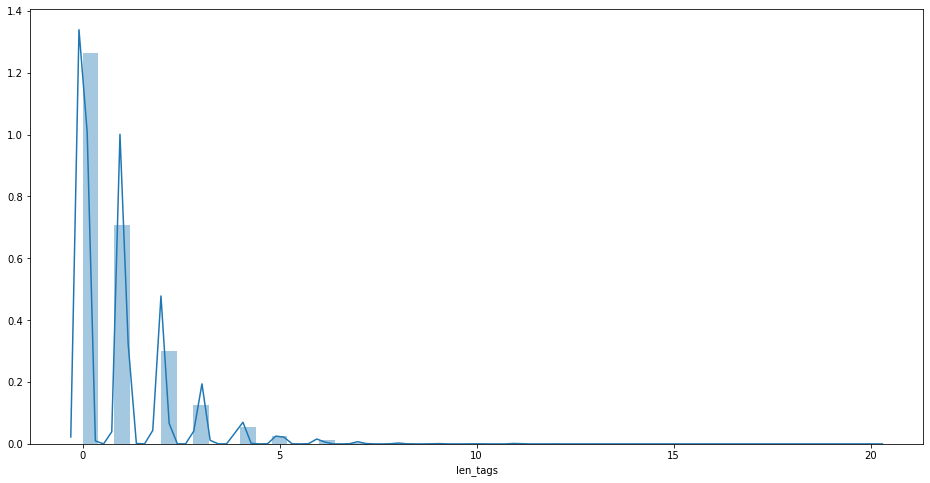

In [15]:
print(tags_81_df.len_tags.describe())
fig, ax = plt.subplots(figsize=(16, 8))
sns.distplot(tags_81_df.len_tags, ax=ax)
plt.show()

<a id="get_important_tags"></a>
# Get important tags
[Back to Table of Contents](#toc)

In [16]:
ground_truth = []
for path in tqdm(list(Path(GT_ROOT).glob('*'))):
    tag = path.name.split('_')[-1].split('.')[0]

    with open(path, 'r') as f:
        content = np.array(f.read().splitlines(), dtype=np.uint)        
        ground_truth.append(np.array(['', tag])[content])

100%|██████████| 81/81 [00:03<00:00, 21.90it/s]


In [17]:
ground_truth = np.array(ground_truth)

In [18]:
ground_truth = [','.join([item for item in items if item != '']) for items in ground_truth.T]

In [19]:
len(ground_truth)

269648

In [20]:
important_tags_81_df = pd.DataFrame({
    'item_id': item_ids,
    'important_tags': ground_truth
})

In [21]:
important_tags_81_df

,item_id,important_tags
0,2124494179,person
1,174174086,person
2,221597162,person
3,540895766,person
4,262041423,person
...,...,...
269643,460543444,"animal,water,bear"
269644,391097803,"animal,birds"
269645,6221368,animal
269646,144768190,"animal,bear"


In [22]:
important_tags_81_df['len_important_tags'] = important_tags_81_df.important_tags.apply(lambda x: len(x.split(',')))

count    269648.000000
mean          2.092168
std           1.512925
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          13.000000
Name: len_important_tags, dtype: float64


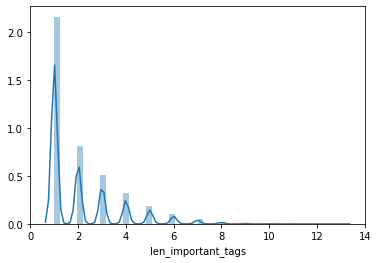

In [23]:
print(important_tags_81_df.len_important_tags.describe())
sns.distplot(important_tags_81_df.len_important_tags)
plt.show()

<a id="generate_dataset"></a>
# Generate dataset
[Back to Table of Contents](#toc)

In [24]:
df = pd.merge(
    tags_81_df.replace('', np.nan).dropna().drop_duplicates(),
    important_tags_81_df.replace('', np.nan).dropna().drop_duplicates(),
    on='item_id'
)

In [25]:
df

,item_id,tags,len_tags,important_tags,len_important_tags
0,25158805,sports,1,"sky,person",2
1,1106962433,street,1,"clouds,person",2
2,470960261,water,1,"grass,water,sky",3
3,2324200009,moon,1,person,1
4,213660760,plane,1,plane,1
...,...,...,...,...,...
119885,864401461,"birds,tree",2,birds,1
119886,1096302326,animal,1,"animal,water",2
119887,391097803,birds,1,"animal,birds",2
119888,6221368,animal,1,animal,1


In [26]:
df['set_tags'] = df.tags.apply(lambda x: set(x.split(',')))

In [27]:
df['set_important_tags'] = df.important_tags.apply(lambda x: set(x.split(',')))

In [28]:
mask = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    tags = row.set_tags
    important_tags = row.set_important_tags
    if important_tags.issubset(tags):
        mask.append(True)
    else:
        mask.append(False)

100%|██████████| 119890/119890 [00:24<00:00, 4940.25it/s]


In [29]:
df = df.loc[mask]

In [30]:
df

,item_id,tags,len_tags,important_tags,len_important_tags,set_tags,set_important_tags
4,213660760,plane,1,plane,1,{plane},{plane}
7,845243484,"clouds,sky",2,"clouds,sky",2,"{clouds, sky}","{clouds, sky}"
12,1224483022,"clouds,sky,sunset",3,"clouds,sunset,sky",3,"{clouds, sunset, sky}","{clouds, sunset, sky}"
25,2232648051,window,1,window,1,{window},{window}
35,2504620853,street,1,street,1,{street},{street}
...,...,...,...,...,...,...,...
119883,2470198185,"animal,bear",2,"animal,bear",2,"{animal, bear}","{animal, bear}"
119884,197520827,animal,1,animal,1,{animal},{animal}
119885,864401461,"birds,tree",2,birds,1,"{birds, tree}",{birds}
119888,6221368,animal,1,animal,1,{animal},{animal}


26559


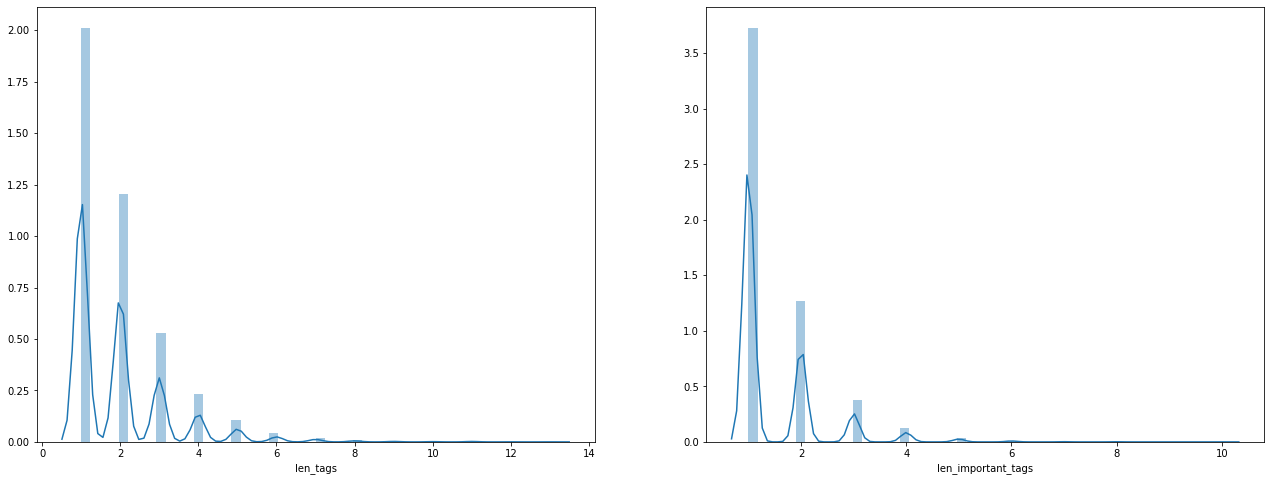

In [31]:
print(len(df))
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
sns.distplot(df.len_tags, ax=axes[0])
sns.distplot(df.len_important_tags, ax=axes[1])
plt.show()

In [32]:
df = df.loc[df.len_tags <= MAX_LEN]

26559


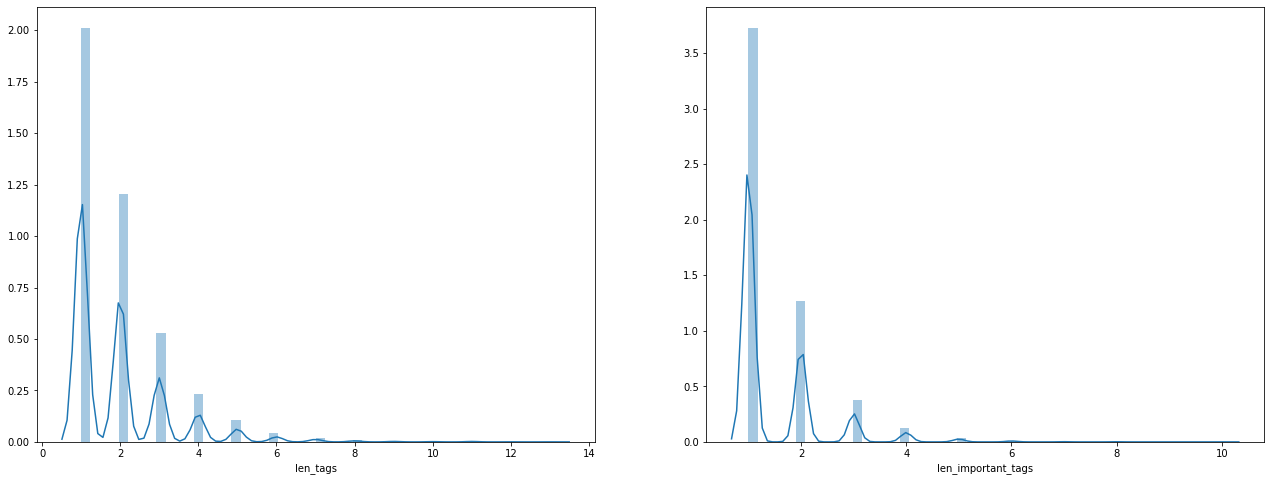

In [33]:
print(len(df))
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
sns.distplot(df.len_tags, ax=axes[0])
sns.distplot(df.len_important_tags, ax=axes[1])
plt.show()

In [34]:
df.loc[:, 'ratio'] = df.len_important_tags / df.len_tags

In [35]:
df['ratio'].describe()

count    26559.000000
mean         0.850118
std          0.232185
min          0.090909
25%          0.666667
50%          1.000000
75%          1.000000
max          1.000000
Name: ratio, dtype: float64

In [36]:
df

,item_id,tags,len_tags,important_tags,len_important_tags,set_tags,set_important_tags,ratio
4,213660760,plane,1,plane,1,{plane},{plane},1.0
7,845243484,"clouds,sky",2,"clouds,sky",2,"{clouds, sky}","{clouds, sky}",1.0
12,1224483022,"clouds,sky,sunset",3,"clouds,sunset,sky",3,"{clouds, sunset, sky}","{clouds, sunset, sky}",1.0
25,2232648051,window,1,window,1,{window},{window},1.0
35,2504620853,street,1,street,1,{street},{street},1.0
...,...,...,...,...,...,...,...,...
119883,2470198185,"animal,bear",2,"animal,bear",2,"{animal, bear}","{animal, bear}",1.0
119884,197520827,animal,1,animal,1,{animal},{animal},1.0
119885,864401461,"birds,tree",2,birds,1,"{birds, tree}",{birds},0.5
119888,6221368,animal,1,animal,1,{animal},{animal},1.0


<a id="split_dataset"></a>
# Split dataset into training and validation sets
[Back to Table of Contents](#toc)

## Get the list of training items

In [37]:
with open(TRAIN_IMAGE_LIST_PATH, 'r') as f:
    lines = f.read().splitlines()

In [38]:
lines[0]

'actor\\0001_2124494179.jpg'

In [39]:
cats, item_ids = [], []

for line in tqdm(lines):
    parts = line.split('_')
    item_ids.append(parts[-1].split('.')[0])
    cats.append(parts[0].split('\\')[0])

100%|██████████| 161789/161789 [00:00<00:00, 594936.97it/s]


In [40]:
len(item_ids), len(cats)

(161789, 161789)

In [41]:
train_split_df = pd.DataFrame({
    'item_id': item_ids,
    'category': cats
})

In [42]:
train_split_df

,item_id,category
0,2124494179,actor
1,221597162,actor
2,540895766,actor
3,2171575576,actor
4,2217003708,actor
...,...,...
161784,856379207,zoos
161785,2063588031,zoos
161786,460543444,zoos
161787,6221368,zoos


In [43]:
train_split_df.groupby('category').count().describe()

,item_id
count,661.000000
mean,244.763994
std,101.795243
min,1.000000
25%,207.000000
50%,264.000000
75%,293.000000
max,916.000000


## Get the list of validation items

In [44]:
with open(VAL_IMAGE_LIST_PATH, 'r') as f:
    lines = f.read().splitlines()

In [45]:
lines[0]

'actor\\0002_174174086.jpg'

In [46]:
cats, item_ids = [], []

for line in tqdm(lines):
    parts = line.split('_')
    item_ids.append(parts[-1].split('.')[0])
    cats.append(parts[0].split('\\')[0])

100%|██████████| 107859/107859 [00:00<00:00, 588682.19it/s]


In [47]:
len(item_ids), len(cats)

(107859, 107859)

In [48]:
val_split_df = pd.DataFrame({
    'item_id': item_ids,
    'category': cats
})

In [49]:
val_split_df

,item_id,category
0,174174086,actor
1,262041423,actor
2,25158805,actor
3,6804082,actor
4,797603127,actor
...,...,...
107854,2725577417,zoos
107855,864401461,zoos
107856,1096302326,zoos
107857,391097803,zoos


In [50]:
val_split_df.groupby('category').count().describe()

,item_id
count,661.000000
mean,163.175492
std,67.870595
min,1.000000
25%,138.000000
50%,176.000000
75%,196.000000
max,611.000000


## Split dataset

In [51]:
train_list = train_split_df.item_id.tolist()

In [52]:
val_list = val_split_df.item_id.tolist()

In [53]:
df.set_index('item_id', inplace=True)

In [54]:
train_df = df.loc[df.index.isin(train_list), ['tags', 'important_tags']]

In [55]:
train_df

,tags,important_tags
item_id,,
213660760,plane,plane
2504620853,street,street
1443282401,dancing,dancing
534152430,cat,cat
2102538703,"snow,street",snow
...,...,...
2471021766,"animal,bear","animal,bear"
2634224846,birds,birds
2470198185,"animal,bear","animal,bear"


In [56]:
train_df.to_csv(TRAIN_SAVE_PATH)

In [57]:
val_df = df.loc[df.index.isin(val_list), ['tags', 'important_tags']]

In [58]:
val_df

,tags,important_tags
item_id,,
845243484,"clouds,sky","clouds,sky"
1224483022,"clouds,sky,sunset","clouds,sunset,sky"
2232648051,window,window
1011749855,wedding,wedding
2647088981,person,person
...,...,...
144769204,"animal,bear","animal,bear"
419763644,"animal,tiger","animal,tiger"
303420559,animal,animal


In [59]:
val_df.to_csv(VAL_SAVE_PATH)

<a id="generate_vocab"></a>
# Generate vocabulary
[Back to Table of Contents](#toc)

In [60]:
len(concepts81)

81

In [61]:
vocab_df = pd.DataFrame({
    'index': list(range(len(concepts81))),
    'word': concepts81
})

In [62]:
vocab_df

,index,word
0,0,airport
1,1,animal
2,2,beach
3,3,bear
4,4,birds
...,...,...
76,76,waterfall
77,77,wedding
78,78,whales
79,79,window


In [63]:
vocab_df.to_csv(VOCAB_SAVE_PATH, index=False)